<a href="https://colab.research.google.com/github/heejjj/Heart_Attact_Predict/blob/heejjj_edit/Heart_Attack_Analysis_%26_Prediction_%EC%88%98%EC%A0%95%EC%88%98%EC%A0%95%EC%88%98%EC%A0%95%EC%A4%91%EC%88%98%EC%A0%95%EC%88%98%EC%A0%95%EC%A4%91_23_04_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
from sklearn.model_selection import (cross_val_score,train_test_split,GridSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error,accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report,precision_score)
from sklearn.dummy import DummyClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from yellowbrick.classifier import ROCAUC
import warnings
warnings.filterwarnings('ignore')
sns.set(font_scale=1.2)


age: Mean age is 55 years. Most subjects are around the range of age of 48 to 61.

sex: Most (by a little margin) of subjects in the dataset seem to be MALE.

cp: Mean value for the chest pain type seems to be around the range "Value 0 to Value 2".

trtbps: The resting blood pressure(mmHg) of the dataset seems to be mostly around 120mmHg to 140mmHg.

chol: This one is interesting because the majority of the data seems to be around 211.00 mm/dl to 274.50 mm/dl but there seems to a few outliers (max being 564.00 mm/dl). Since I'm not a subject expert on this topic I will not eliminate the outlier’s instances.

fbs: Most people in the dataset seem to have fasting blood sugar > 120 mg/dl.

restecg: Values are distributed almost equally between Value=0 "Normal" and Value=1 "Having ST-T wave abnormality" with very few cases of Value 2 popping in the dataset.

thalachh: The maximum heart rate archived of the subjects seems to be around 153.00 bmp which is high is high while exercising, but I assume this is the rate recorded while being in a resting position inside the hospital. If this is the rate while resting i'd say it's quite high since average resting rate is 73 bmp for folks around the age of 48 to 61.

exng: Exercise induced angina seems to be more skewed to Value=0 "No.

oldpeak: Not sure about this feature but it seems the lower the value the more likely the subject has heart related diseases.

slp: Most of the values are between Value=1 "Flat" and Value=2 "Downsloping" with a very few cases of Value=0 "upsloping".

caa: Data seems to lean more toward Value=0 which is 0 major vessels colored by fluoroscopy. There also seems to be a few instances with Value=4(very rare cases).

thall: There seems to be an error with this feature, the data card specifies only 3 possible values, but it seems the dataset has up to 4 values. I Think Value=0 is an encoding error. Still the most adopted thru the instances seems to be Value= 2 "fixed defects".

In [2]:
df = pd.read_csv('/content/drive/MyDrive/kaggle/Heart Attack Analysis & Prediction Dataset/heart.csv')


In [3]:
print("dataset shape:", df.shape)

dataset shape: (303, 14)


In [4]:
df.sample(5)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
157,35,1,1,122,192,0,1,174,0,0.0,2,0,2,1
213,61,0,0,145,307,0,0,146,1,1.0,1,0,3,0
36,54,0,2,135,304,1,1,170,0,0.0,2,0,2,1
45,52,1,1,120,325,0,1,172,0,0.2,2,0,2,1
81,45,1,1,128,308,0,0,170,0,0.0,2,0,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


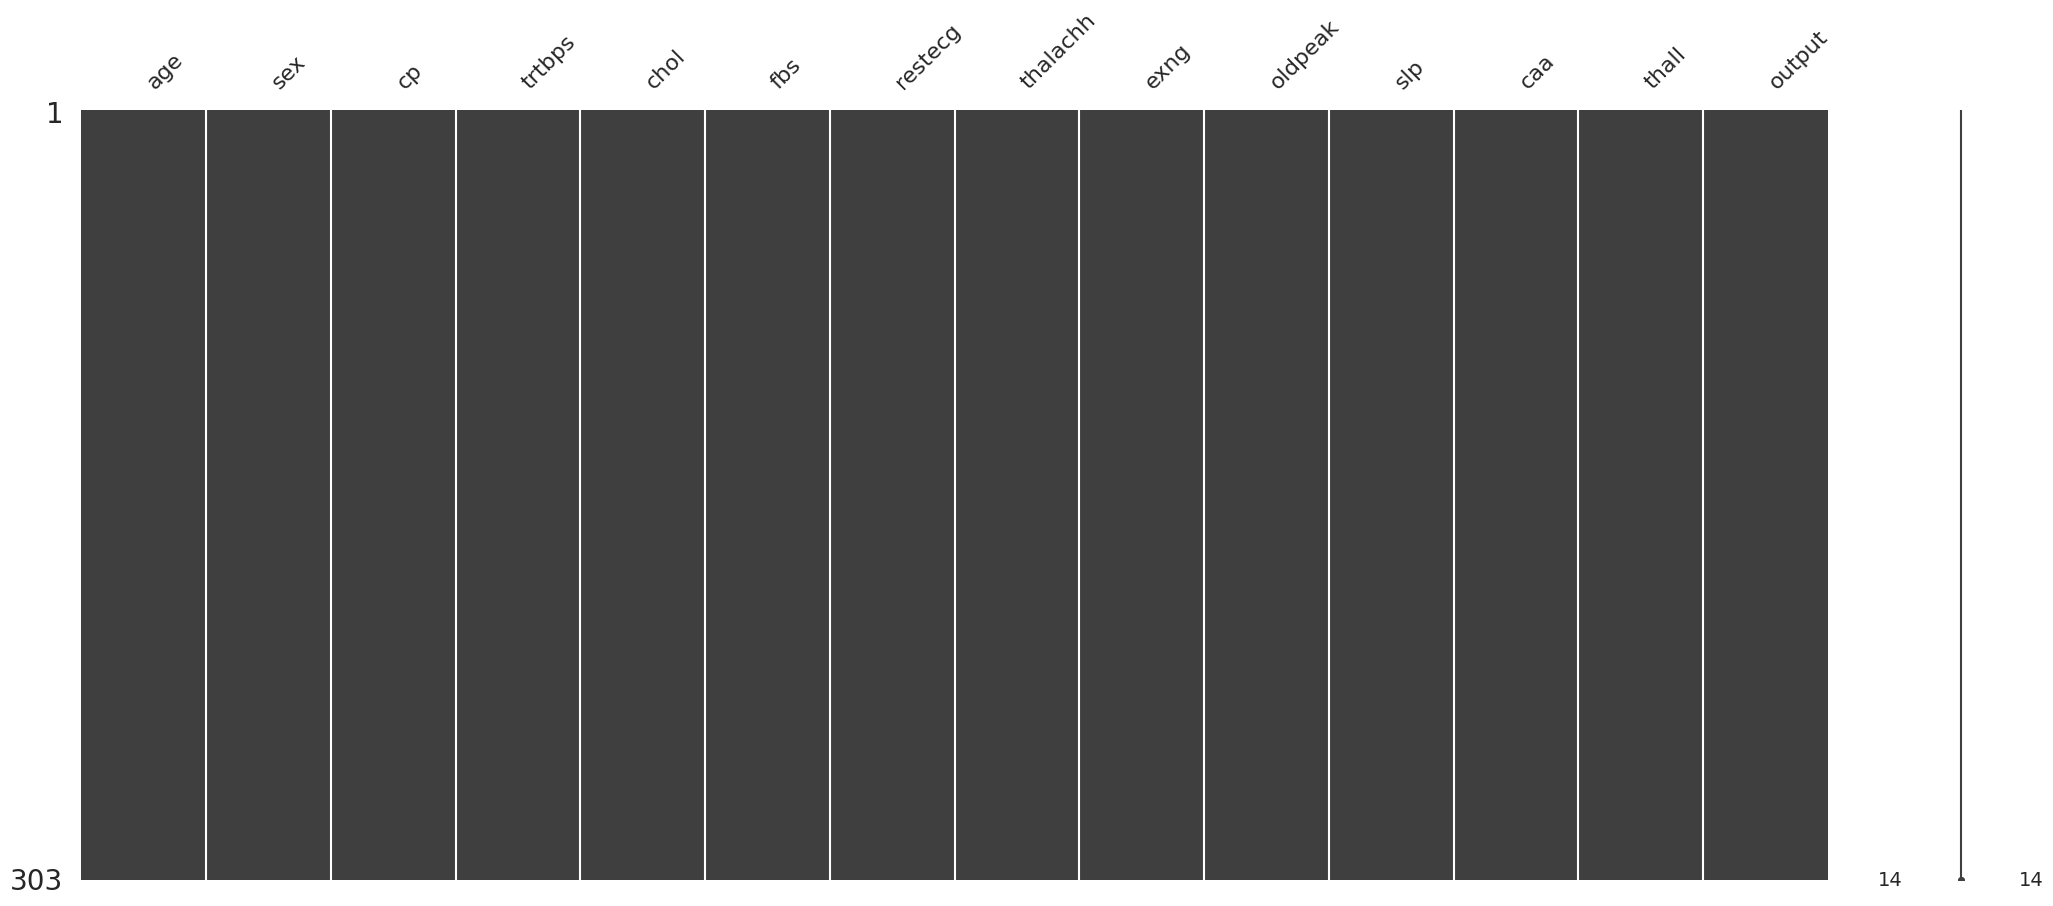

In [6]:
ax= msno.matrix(df)

In [7]:

dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique value count"]).transpose().sort_values(by=["unique value count"], ascending=False)

,unique value count
chol,152
thalachh,91
trtbps,49
age,41
oldpeak,40
caa,5
cp,4
thall,4
restecg,3
slp,3


In [8]:
df_copy=df.copy()

In [9]:
y= df_copy['output']
x=df_copy.drop(['output'],axis=1)
x.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [10]:
y.value_counts()

1    165
0    138
Name: output, dtype: int64

In [11]:
   # Value 0 = 138, Value 1 = 165
Value_1, Value_0 = y.value_counts()
print('less chance of heart attack: ',Value_0)
print('more chance of heart attack : ',Value_1)

less chance of heart attack:  138
more chance of heart attack :  165


In [12]:
x.describe().round(2)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00
mean,54.37,0.68,0.97,131.62,246.26,0.15,0.53,149.65,0.33,1.04,1.40,0.73,2.31
std,9.08,0.47,1.03,17.54,51.83,0.36,0.53,22.91,0.47,1.16,0.62,1.02,0.61
min,29.00,0.00,0.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,0.00,0.00,0.00
25%,47.50,0.00,0.00,120.00,211.00,0.00,0.00,133.50,0.00,0.00,1.00,0.00,2.00
50%,55.00,1.00,1.00,130.00,240.00,0.00,1.00,153.00,0.00,0.80,1.00,0.00,2.00
75%,61.00,1.00,2.00,140.00,274.50,0.00,1.00,166.00,1.00,1.60,2.00,1.00,3.00
max,77.00,1.00,3.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,2.00,4.00,3.00


##EDA


In [13]:
col= x.columns
col

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall'],
      dtype='object')

In [14]:
#Categorical features
cat=["sex","cp","restecg","exng","slp","caa","thall","fbs"] 

#Numerical features
num=["age","trtbps","chol","thalachh","oldpeak"] 

categorical


<Axes: xlabel='fbs', ylabel='count'>

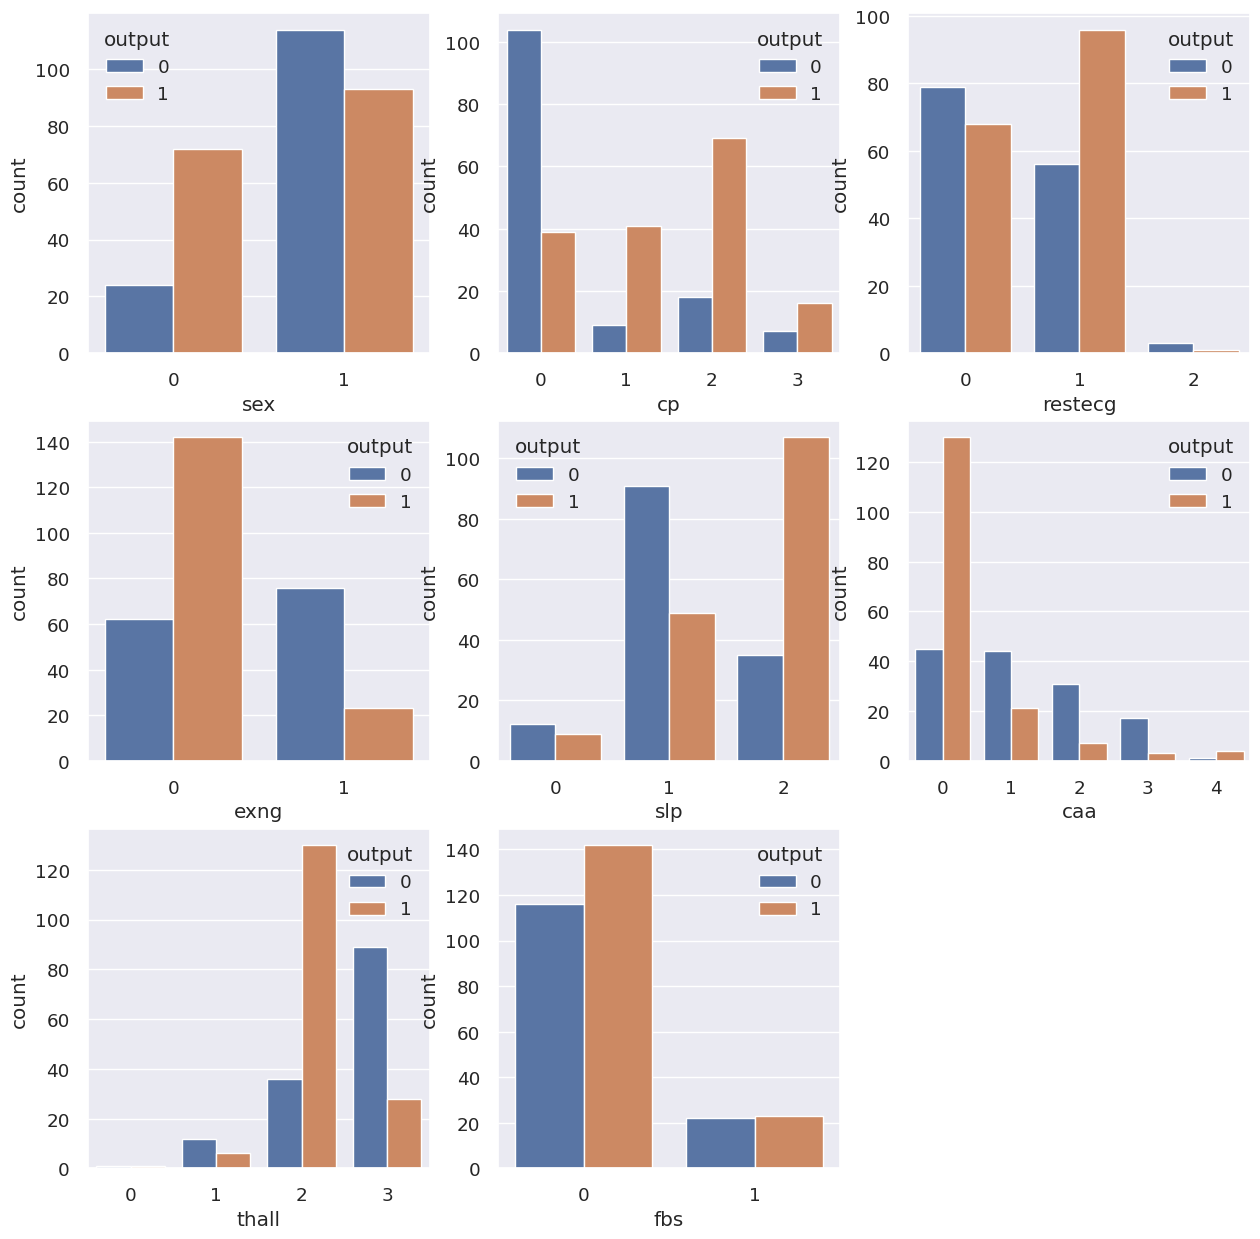

In [15]:
fig=plt.figure(figsize=(15,15))   
gs = fig.add_gridspec(3,3) #3x3 Grid space for our 8 categorical features.
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[2,1])

sns.countplot(ax=ax0,data=df_copy,x='sex',hue="output")
sns.countplot(ax=ax1,data=df_copy,x='cp',hue="output")
sns.countplot(ax=ax2,data=df_copy,x='restecg',hue="output")
sns.countplot(ax=ax3,data=df_copy,x='exng',hue="output")
sns.countplot(ax=ax4,data=df_copy,x='slp',hue="output")
sns.countplot(ax=ax5,data=df_copy,x='caa',hue="output")
sns.countplot(ax=ax6,data=df_copy,x='thall',hue="output")
sns.countplot(ax=ax7,data=df_copy,x='fbs',hue="output")

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'sex'),
  Text(0, 1.5, 'cp'),
  Text(0, 2.5, 'restecg'),
  Text(0, 3.5, 'exng'),
  Text(0, 4.5, 'slp'),
  Text(0, 5.5, 'caa'),
  Text(0, 6.5, 'thall'),
  Text(0, 7.5, 'fbs')])

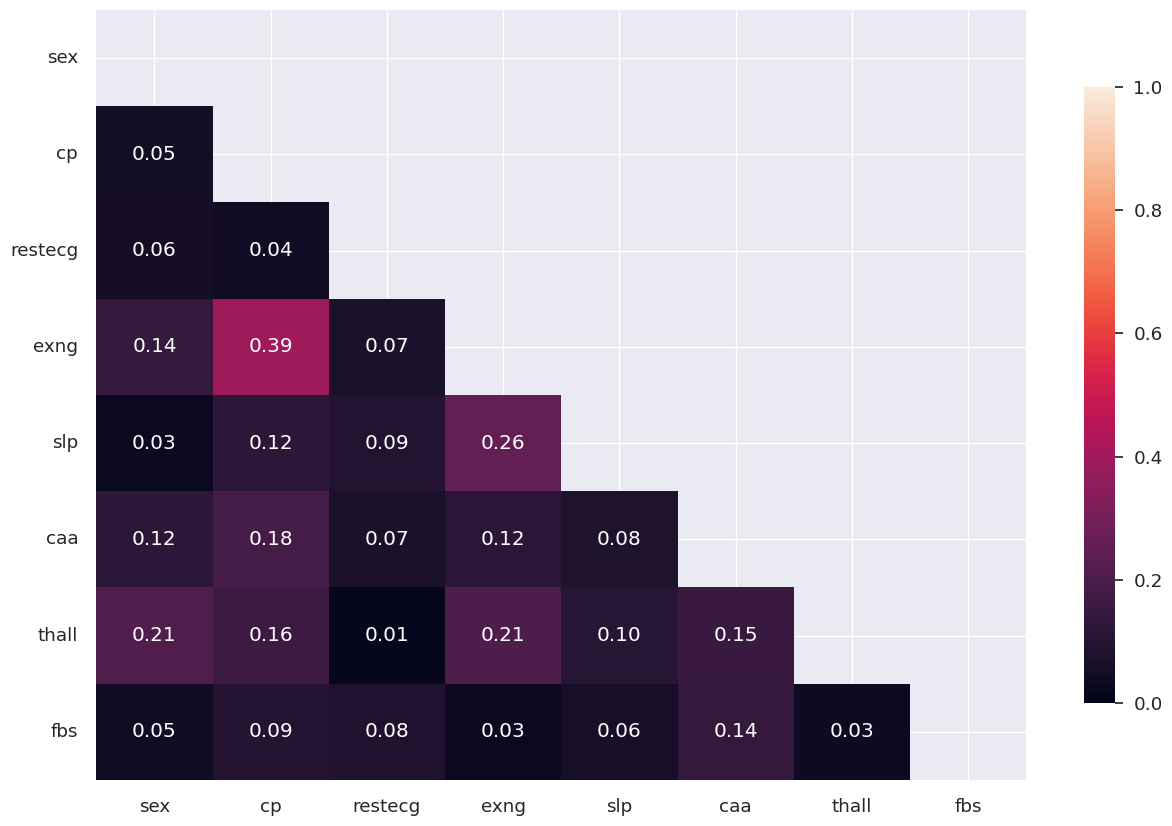

In [16]:
corr= df[cat].corr().abs()
mask= np.triu(np.ones_like(corr,dtype=np.bool))

fig,ax= plt.subplots(figsize=(15,10))

#plot heatmap
sns.heatmap(corr,mask=mask, annot=True, fmt=".2f",cbar_kws={"shrink": .8}, vmin=0, vmax=1)

#yticks
plt.yticks(rotation=0)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'age'),
  Text(1, 0, 'trtbps'),
  Text(2, 0, 'chol'),
  Text(3, 0, 'thalachh'),
  Text(4, 0, 'oldpeak')])

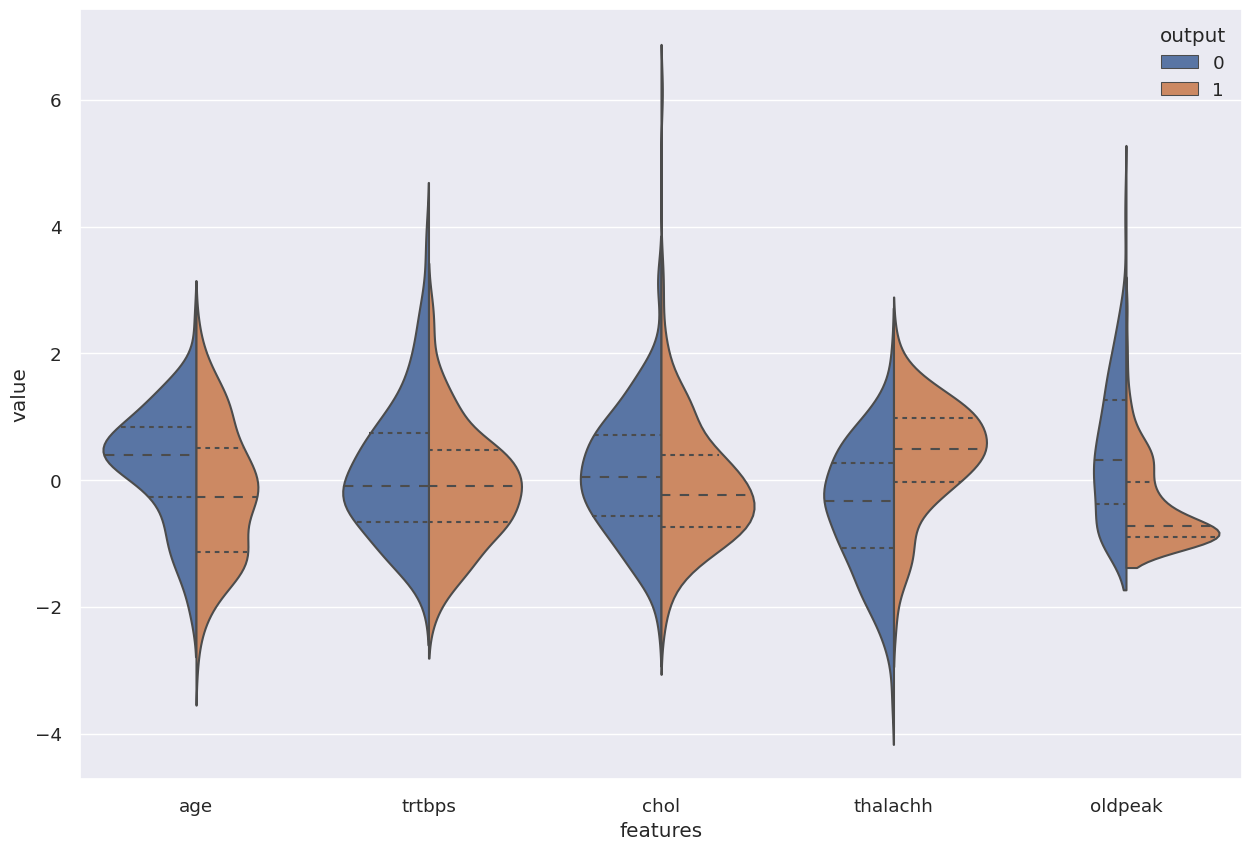

In [17]:
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())      
data_n_2_num= data_n_2[num]
data = pd.concat([y,data_n_2_num],axis=1)
data = pd.melt(data,id_vars="output",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(15,10))      
sns.violinplot(x="features", y="value",hue="output",data=data,split=True,inner="quart")
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'age'),
  Text(1, 0, 'trtbps'),
  Text(2, 0, 'chol'),
  Text(3, 0, 'thalachh'),
  Text(4, 0, 'oldpeak')])

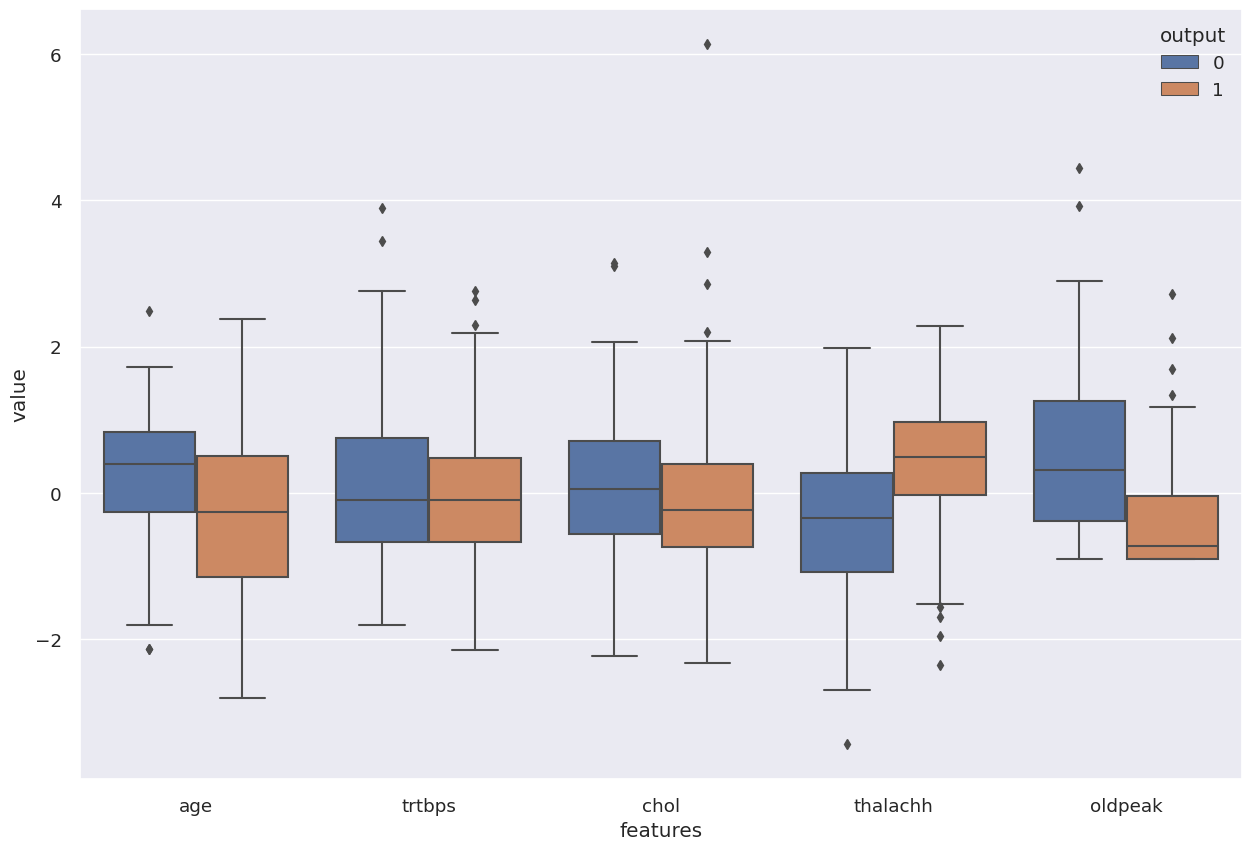

In [18]:
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())    
data_n_2_num= data_n_2[num]
data = pd.concat([y,data_n_2_num],axis=1)
data = pd.melt(data,id_vars="output",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(15,10))      
sns.boxplot(x="features", y="value",hue="output",data=data)
plt.xticks(rotation=0)

numerical


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'age'),
  Text(0, 1.5, 'trtbps'),
  Text(0, 2.5, 'chol'),
  Text(0, 3.5, 'thalachh'),
  Text(0, 4.5, 'oldpeak')])

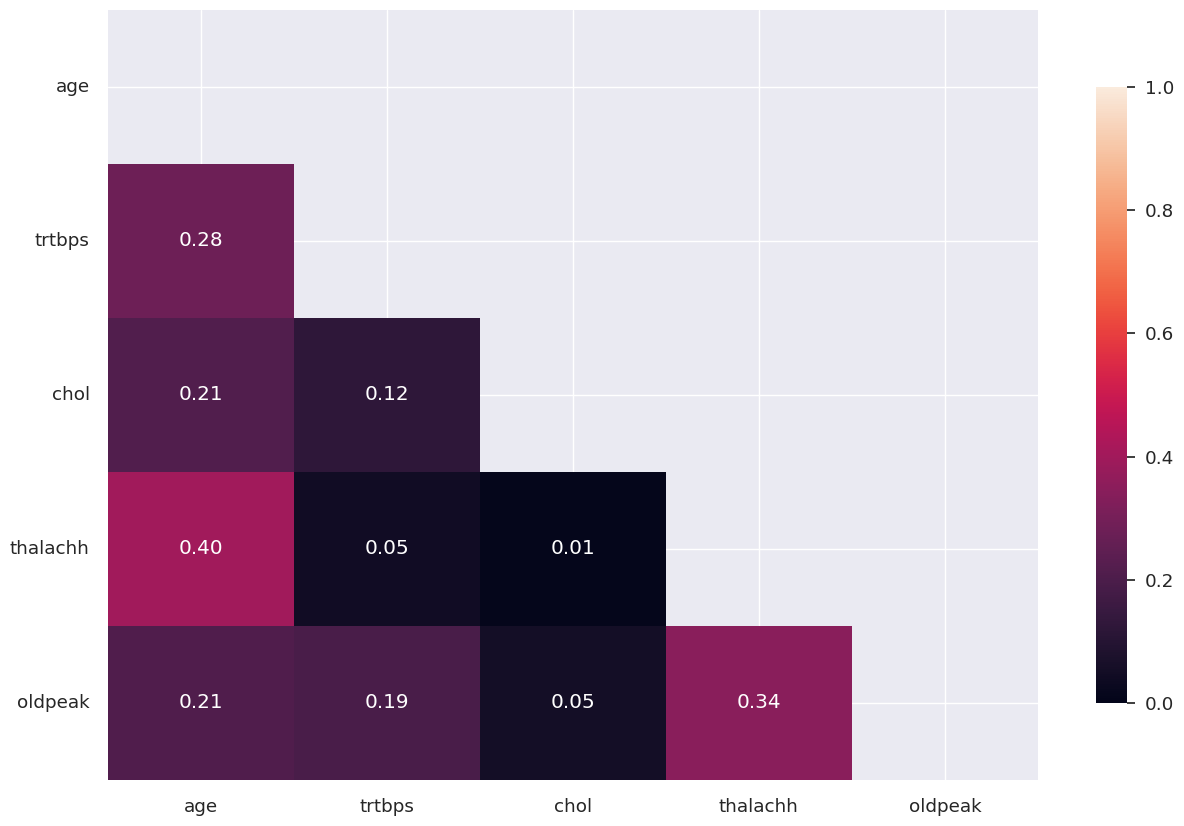

In [19]:
corr= df[num].corr().abs()
mask= np.triu(np.ones_like(corr,dtype=np.bool))

fig,ax= plt.subplots(figsize=(15,10))

#plot heatmap
sns.heatmap(corr,mask=mask, annot=True, fmt=".2f",cbar_kws={"shrink": .8}, vmin=0, vmax=1)

#yticks
plt.yticks(rotation=0)

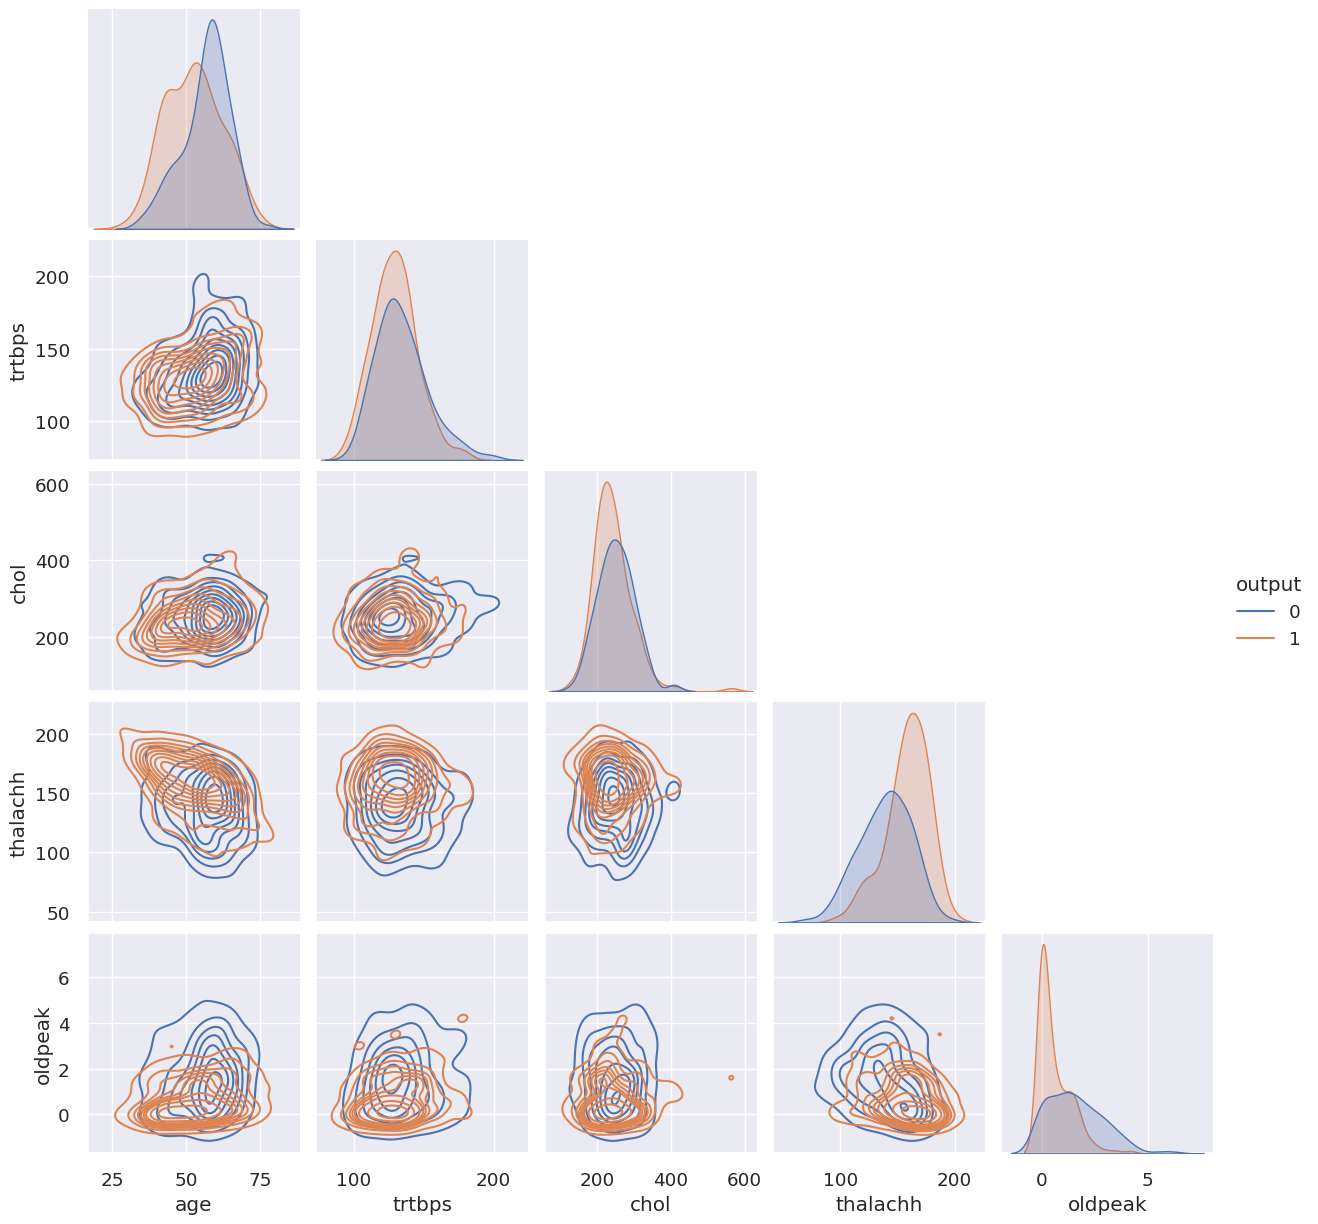

In [20]:
sns.pairplot(data=df,hue='output',x_vars=df[num],y_vars=df[num] ,kind="kde",corner=True)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 [Text(0, 0.5, 'age'),
  Text(0, 1.5, 'sex'),
  Text(0, 2.5, 'cp'),
  Text(0, 3.5, 'trtbps'),
  Text(0, 4.5, 'chol'),
  Text(0, 5.5, 'fbs'),
  Text(0, 6.5, 'restecg'),
  Text(0, 7.5, 'thalachh'),
  Text(0, 8.5, 'exng'),
  Text(0, 9.5, 'oldpeak'),
  Text(0, 10.5, 'slp'),
  Text(0, 11.5, 'caa'),
  Text(0, 12.5, 'thall'),
  Text(0, 13.5, 'output')])

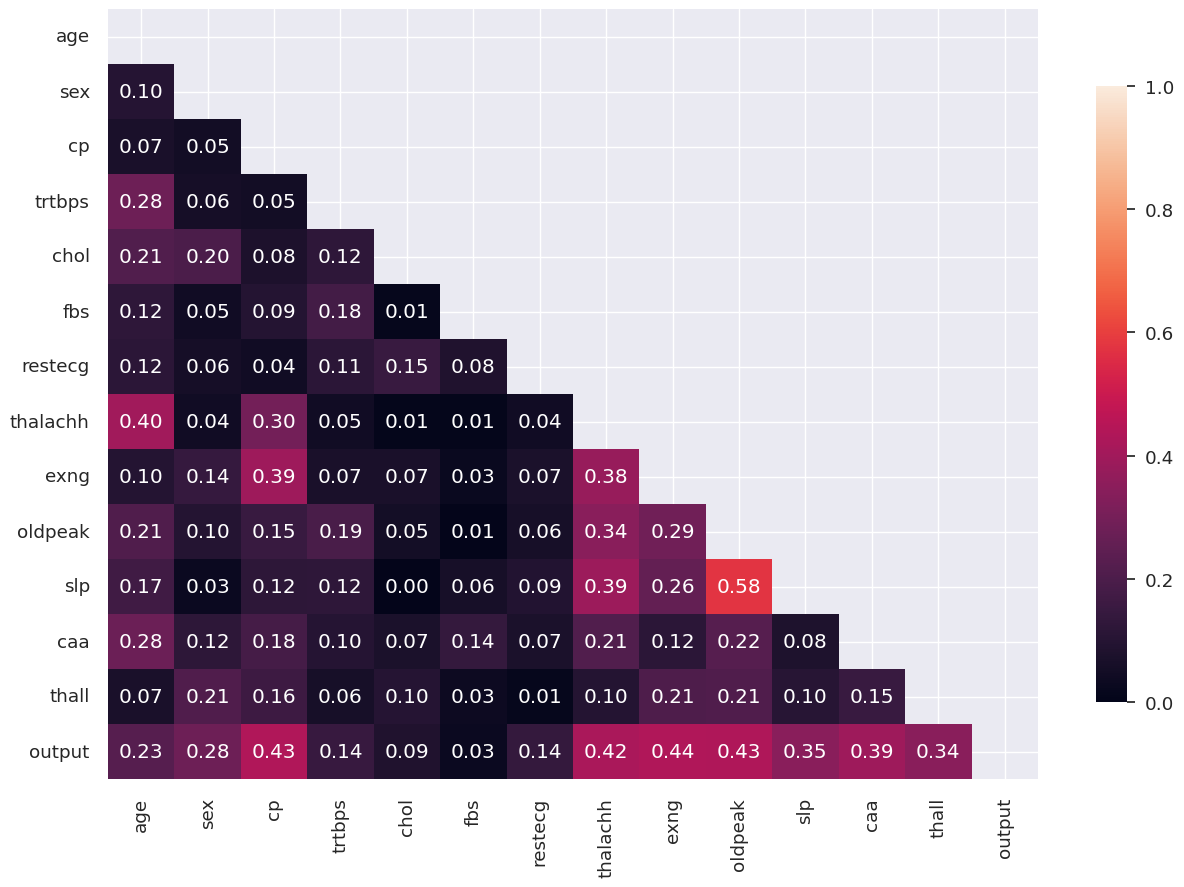

In [21]:
corr= df.corr().abs()
mask= np.triu(np.ones_like(corr,dtype=np.bool))

fig,ax= plt.subplots(figsize=(15,10))

#plot heatmap
sns.heatmap(corr,mask=mask, annot=True, fmt=".2f",cbar_kws={"shrink": .8}, vmin=0, vmax=1)

#yticks
plt.yticks(rotation=0)

In [22]:
x_f=df.drop(['output'],axis=1)
y_f= df[['output']]

scaler = StandardScaler()

x_f[num]=scaler.fit_transform(x_f[num])
x_f.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,0.952197,1,3,0.763956,-0.256334,1,0,0.015443,0,1.087338,0,0,1
1,-1.915313,1,2,-0.092738,0.072199,0,1,1.633471,0,2.122573,0,0,2
2,-1.474158,0,1,-0.092738,-0.816773,0,0,0.977514,0,0.310912,2,0,2
3,0.180175,1,1,-0.663867,-0.198357,0,1,1.239897,0,-0.206705,2,0,2
4,0.290464,0,0,-0.663867,2.082050,0,1,0.583939,1,-0.379244,2,0,2


In [23]:
X_train, X_test, y_train, y_test = train_test_split(x_f,y_f, test_size = 0.2, random_state = 0)

In [24]:
bm= DummyClassifier(random_state = 0)
bm.fit(X_train,y_train)
score_bm=bm.score(X_test, y_test)

In [25]:
print("\n\nAccuracy of baseline dummy model is: " + str(score_bm) + " %")



Accuracy of baseline dummy model is: 0.5573770491803278 %


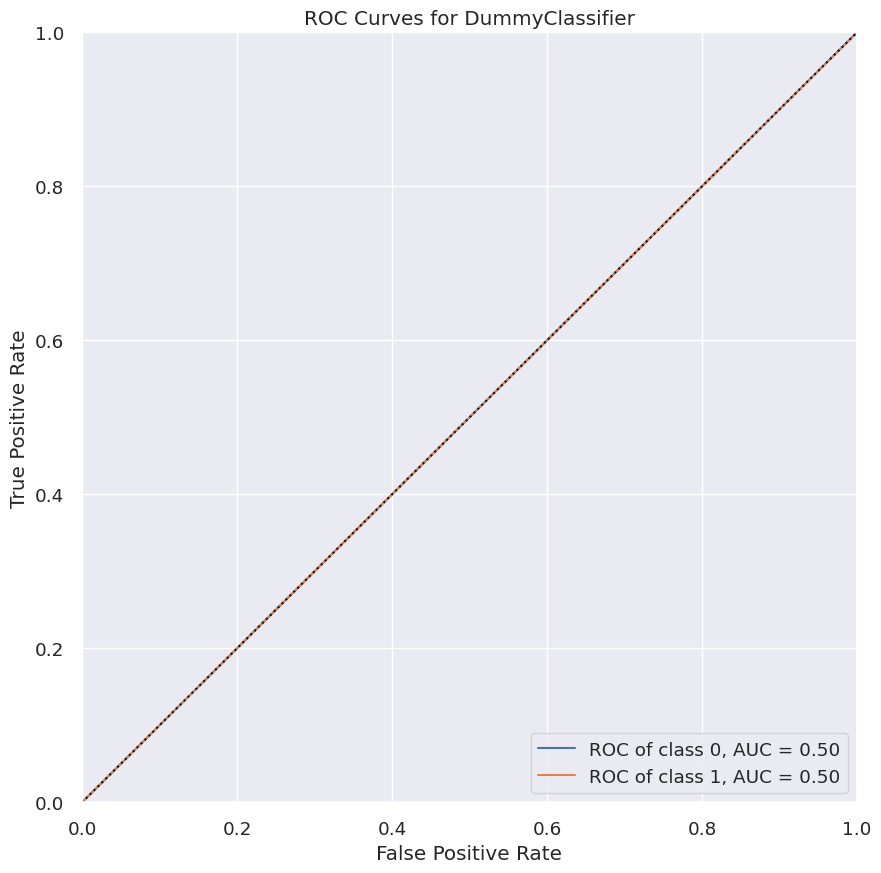

<Axes: title={'center': 'ROC Curves for DummyClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [26]:
fig,ax= plt.subplots(figsize=(10,10))
roc_viz= ROCAUC(bm,micro=False,macro=False, classes=["0", "1"])
roc_viz.fit(X_train,y_train)
roc_viz.score(X_test, y_test)
roc_viz.show()

In [27]:

model_xgb = XGBClassifier(random_state = 0)


model_xgb.fit(X_train, y_train)


y_xgb = model_xgb.predict(X_test)


acc_xgb = round(accuracy_score(y_test, y_xgb),4)*100

print("\n\nAccuracy with untuned XGBoost is: " + str(acc_xgb) + " %")



Accuracy with untuned XGBoost is: 78.69 %


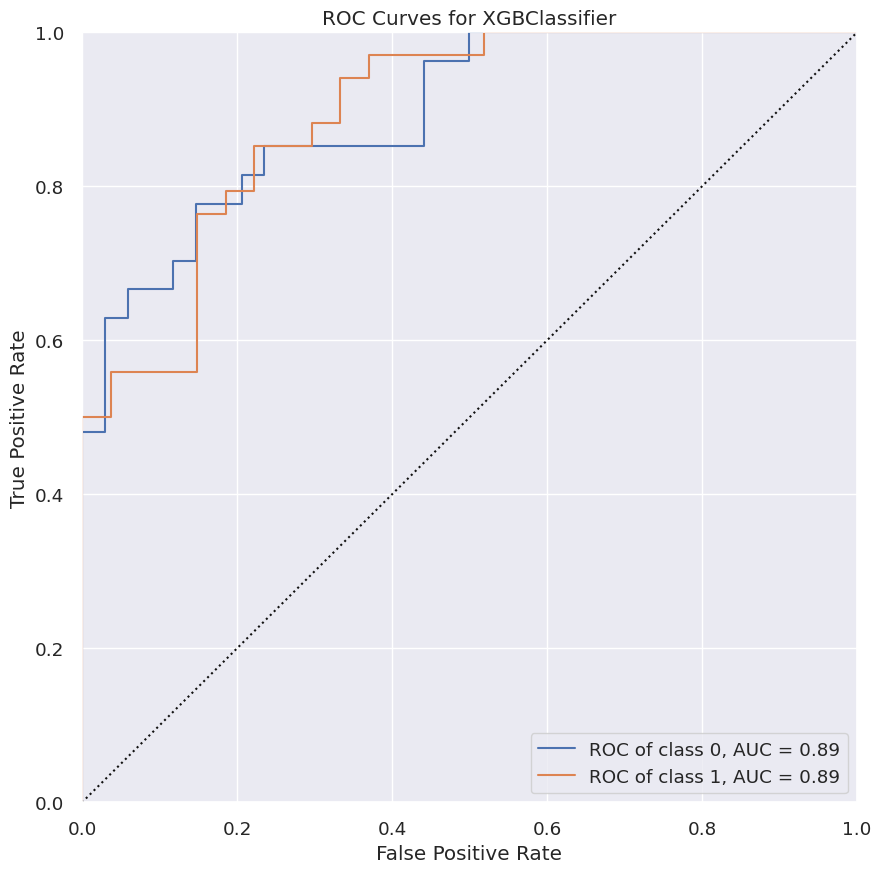

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [28]:
fig,ax= plt.subplots(figsize=(10,10))
roc_viz= ROCAUC(model_xgb,micro=False,macro=False, classes=["0", "1"])
roc_viz.fit(X_train,y_train)
roc_viz.score(X_test, y_test)
roc_viz.show()

Text(0, 0.5, 'True class\n')

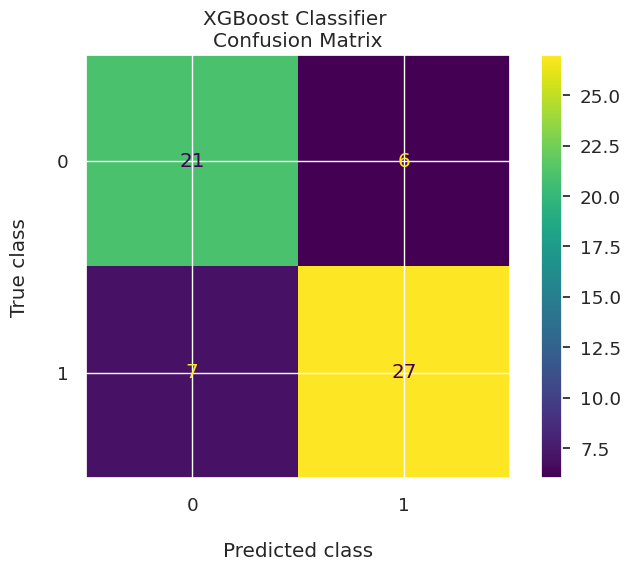

In [29]:
cm_xgb = confusion_matrix(y_test, y_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['0', '1'])

disp_xgb.plot()
plt.title('XGBoost Classifier \nConfusion Matrix')
plt.xlabel('\nPredicted class')
plt.ylabel('True class\n')

In [30]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6],
        }

model_xgb_GCV= XGBClassifier(learning_rate=0.05,
                            n_estimators=400,
                            objective="binary:logistic",
                            reg_alpha=2,
                            reg_lambda=2,
                            random_state=0,
                            )

grid_search=GridSearchCV(model_xgb_GCV,
                         param_grid=params,
                         scoring='roc_auc',
                         cv=5, 
                         verbose=True
                         )

#Training the model
grid_search.fit(X_train, y_train)


print('\n Best hyperparameters:')
print(grid_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

 Best hyperparameters:
{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6}


In [31]:
y_xgb = grid_search.predict(X_test)

#Accuracy
acc_xgb = round(accuracy_score(y_test, y_xgb),4)*100

print("\n\nAccuracy with tuned XGBoost is: " + str(acc_xgb) + " %")



Accuracy with tuned XGBoost is: 85.25 %


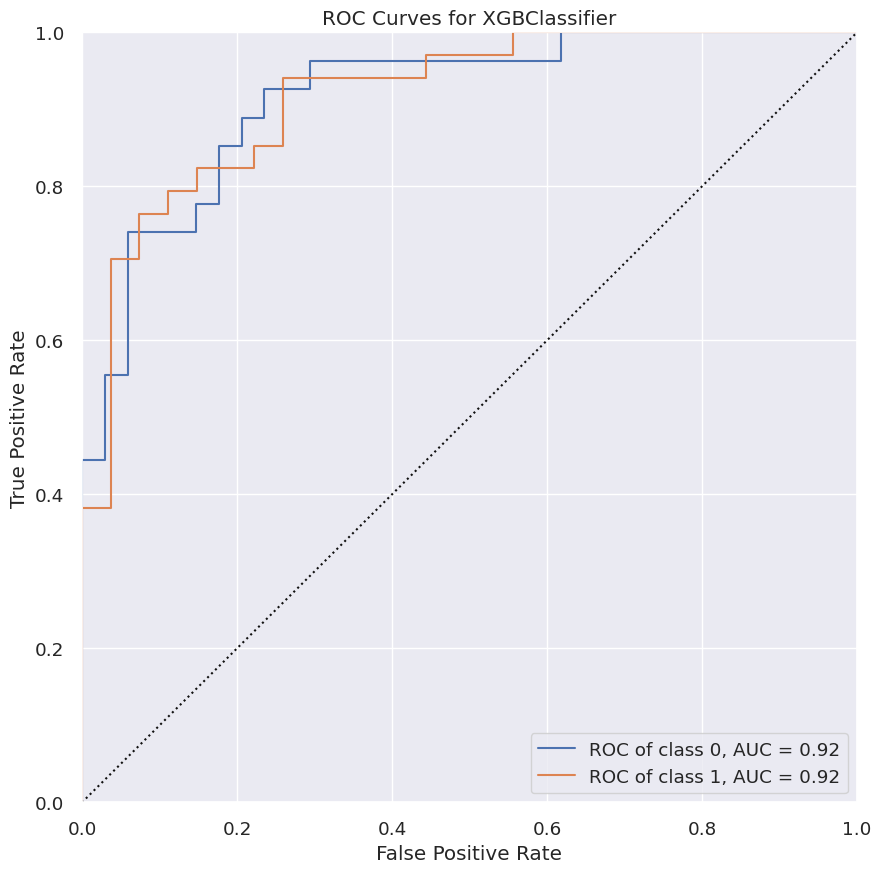

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [32]:
fig,ax= plt.subplots(figsize=(10,10))
roc_viz= ROCAUC(model_xgb_GCV,micro=False,macro=False, classes=["0", "1"])
roc_viz.fit(X_train,y_train)
roc_viz.score(X_test, y_test)
roc_viz.show()

Text(0, 0.5, 'True class\n')

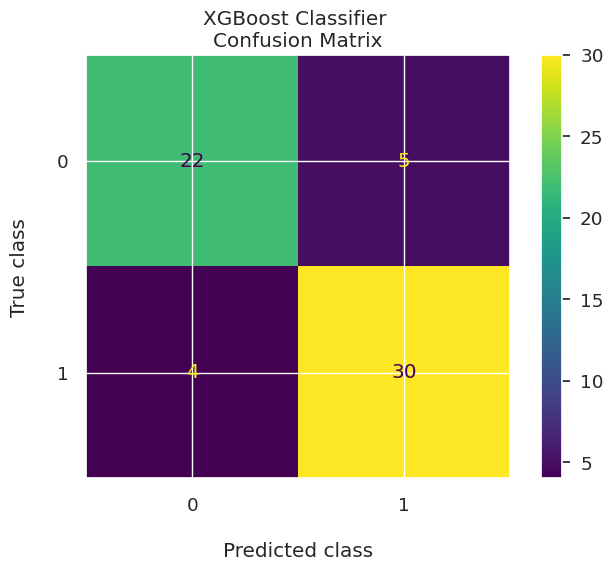

In [33]:
cm_xgb = confusion_matrix(y_test, y_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['0', '1'])

disp_xgb.plot()
plt.title('XGBoost Classifier \nConfusion Matrix')
plt.xlabel('\nPredicted class')
plt.ylabel('True class\n')

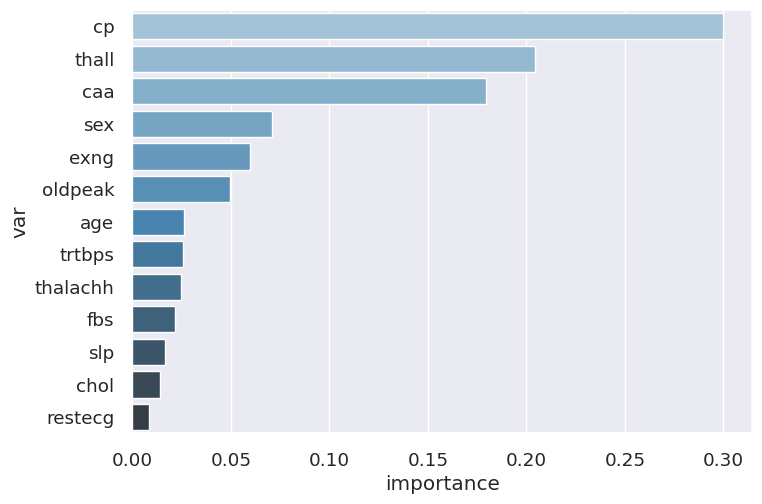

In [34]:
xgb_var_imp_df = pd.DataFrame({'var':X_train.columns,
                              'importance':model_xgb_GCV.feature_importances_}).sort_values(by='importance',ascending=False)


sns.barplot(data=xgb_var_imp_df, y='var', x='importance', orient='h', palette='Blues_d')
ax.set_title('Features Importance')
ax.set_ylabel('')
ax.set_xlabel('Importance Score')
ax.tick_params(axis='y', labelrotation=10)

plt.show()

In [35]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

In [51]:
import numpy as np
import optuna

import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb


def objective(trial):
    
    train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-04-21 06:35:29,558] A new study created in memory with name: no-name-5f3504d2-3563-41f4-98b6-8ab3e0d7d998
[I 2023-04-21 06:35:29,572] Trial 0 finished with value: 0.8421052631578947 and parameters: {'booster': 'gblinear', 'lambda': 4.512602000011524e-08, 'alpha': 3.0090548968091517e-05, 'subsample': 0.6094435641276275, 'colsample_bytree': 0.22698967638119838}. Best is trial 0 with value: 0.8421052631578947.
[I 2023-04-21 06:35:29,581] Trial 1 finished with value: 0.9342105263157895 and parameters: {'booster': 'gblinear', 'lambda': 0.09536079331994103, 'alpha': 1.4012212896394093e-08, 'subsample': 0.41343450886558514, 'colsample_bytree': 0.7976834750807387}. Best is trial 1 with value: 0.9342105263157895.
[I 2023-04-21 06:35:29,594] Trial 2 finished with value: 0.7368421052631579 and parameters: {'booster': 'gbtree', 'lambda': 1.330289935594324e-06, 'alpha': 0.0005030542684338645, 'subsample': 0.9462742502924859, 'colsample_bytree': 0.37330379795156843, 'max_depth': 9, 'min_chil

Number of finished trials:  100
Best trial:
  Value: 0.9342105263157895
  Params: 
    booster: gblinear
    lambda: 0.09536079331994103
    alpha: 1.4012212896394093e-08
    subsample: 0.41343450886558514
    colsample_bytree: 0.7976834750807387


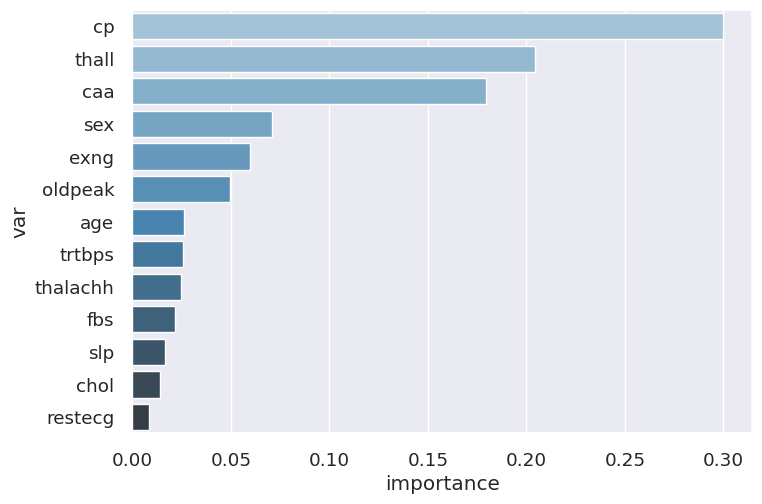

In [38]:
xgb_var_imp_df = pd.DataFrame({'var':X_train.columns,
                              'importance':model_xgb_GCV.feature_importances_}).sort_values(by='importance',ascending=False)


sns.barplot(data=xgb_var_imp_df, y='var', x='importance', orient='h', palette='Blues_d')
ax.set_title('Features Importance')
ax.set_ylabel('')
ax.set_xlabel('Importance Score')
ax.tick_params(axis='y', labelrotation=10)

plt.show()

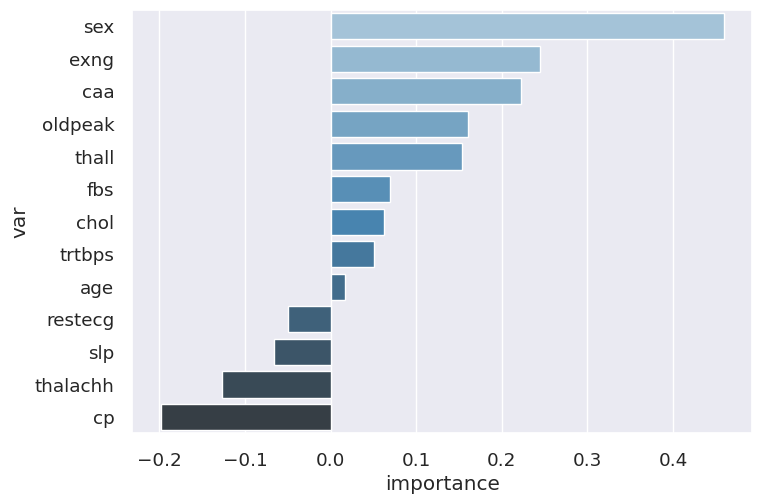

In [43]:
xgb_var_imp_df = pd.DataFrame({'var':X_train.columns,
                              'importance':model_xgb2.feature_importances_}).sort_values(by='importance',ascending=False)


sns.barplot(data=xgb_var_imp_df, y='var', x='importance', orient='h', palette='Blues_d')
ax.set_title('Features Importance')
ax.set_ylabel('')
ax.set_xlabel('Importance Score')
ax.tick_params(axis='y', labelrotation=10)

plt.show()

In [41]:
model_xgb2 = XGBClassifier(booster='gblinear',reg_lambda=0.0007725497127583438,reg_alpha=0.0004381933089779054,subsample=0.35797787695908984,colsample_bytree=0.28100025284487157)

model_xgb2.fit(X_train, y_train)

y_xgb = model_xgb2.predict(X_test)

acc_xgb = round(accuracy_score(y_test, y_xgb),4)*100

print("\n\nAccuracy with  XGBoost is: " + str(acc_xgb) + " %")



Accuracy with  XGBoost is: 85.25 %


In [42]:
model_xgb3 = XGBClassifier()

model_xgb3.fit(X_train, y_train)

y_xgb = model_xgb3.predict(X_test)

acc_xgb = round(accuracy_score(y_test, y_xgb),4)*100

print("\n\nAccuracy with  XGBoost is: " + str(acc_xgb) + " %")



Accuracy with  XGBoost is: 78.69 %


In [45]:
## dart, linear 제거 

import numpy as np
import optuna

import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb


def objective(trial):
    
    train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-04-21 06:30:01,746] A new study created in memory with name: no-name-ed7ca1bd-4f4b-462a-9e9c-343a217c7198
[I 2023-04-21 06:30:01,774] Trial 0 finished with value: 0.7763157894736842 and parameters: {'booster': 'gbtree', 'lambda': 3.7620539237033213e-06, 'alpha': 0.6973576044231952, 'subsample': 0.449141100376276, 'colsample_bytree': 0.7597067066702887, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.0003844048043101472, 'gamma': 0.29501585275047215, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.7763157894736842.
[I 2023-04-21 06:30:01,787] Trial 1 finished with value: 0.7894736842105263 and parameters: {'booster': 'gbtree', 'lambda': 6.563904744370582e-05, 'alpha': 0.0017576918779401802, 'subsample': 0.9936439584638179, 'colsample_bytree': 0.6229908257074166, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.00015940139125076203, 'gamma': 3.0578196958773255e-06, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.7894736842105263.
[I 2023-04-21 06:30:01,813] T

Number of finished trials:  100
Best trial:
  Value: 0.9078947368421053
  Params: 
    booster: gbtree
    lambda: 4.695015079962939e-07
    alpha: 0.013778711395870872
    subsample: 0.8705974322985823
    colsample_bytree: 0.5098209644232834
    max_depth: 3
    min_child_weight: 7
    eta: 0.10978977190020496
    gamma: 0.0012264245330810232
    grow_policy: depthwise


In [49]:
model_xgb4 = XGBClassifier(reg_lambda=4.695015079962939e-07,reg_alpha=0.013778711395870872,subsample=0.8705974322985823,colsample_bytree=0.5098209644232834,
                           max_depth=3,min_child_weight=7,eta=0.10978977190020496,gamma=0.0012264245330810232,grow_policy='depthwise')

model_xgb4.fit(X_train, y_train)

y_xgb = model_xgb4.predict(X_test)

acc_xgb = round(accuracy_score(y_test, y_xgb),4)*100

print("\n\nAccuracy with  XGBoost is: " + str(acc_xgb) + " %")



Accuracy with  XGBoost is: 83.61 %


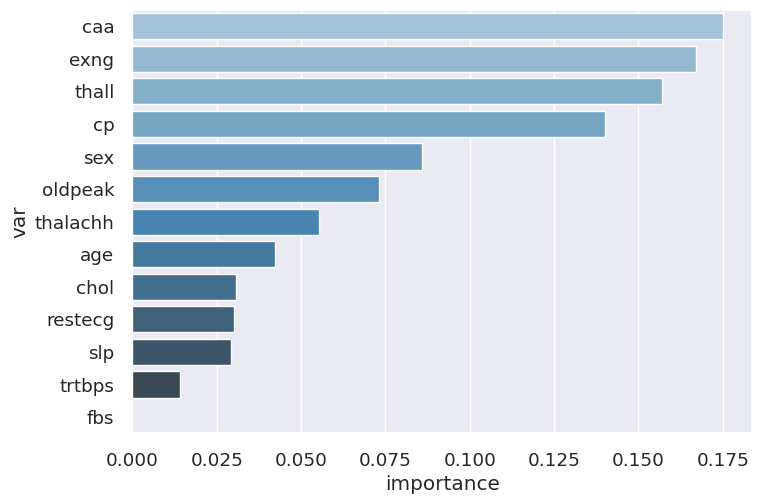

In [50]:
xgb_var_imp_df = pd.DataFrame({'var':X_train.columns,
                              'importance':model_xgb4.feature_importances_}).sort_values(by='importance',ascending=False)


sns.barplot(data=xgb_var_imp_df, y='var', x='importance', orient='h', palette='Blues_d')
ax.set_title('Features Importance')
ax.set_ylabel('')
ax.set_xlabel('Importance Score')
ax.tick_params(axis='y', labelrotation=10)

plt.show()

In [60]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 17.7 MB/s eta 0:00:00


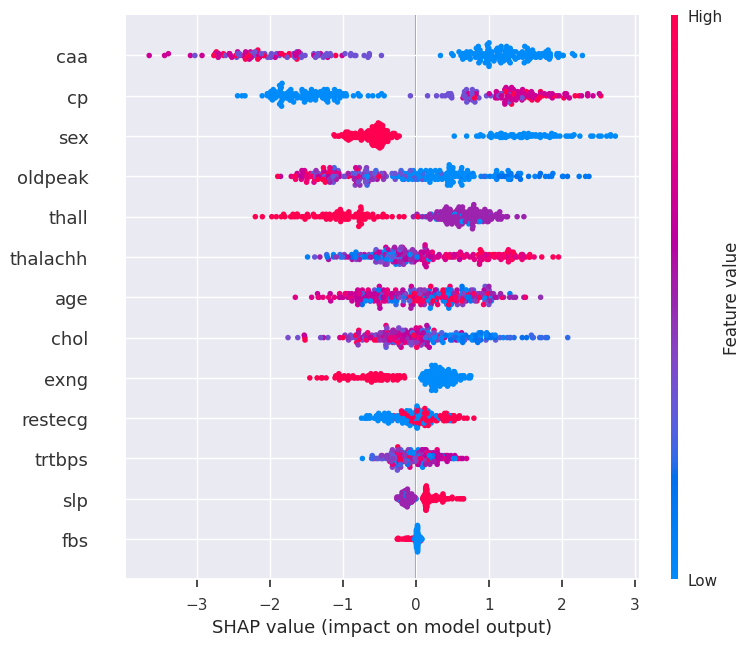

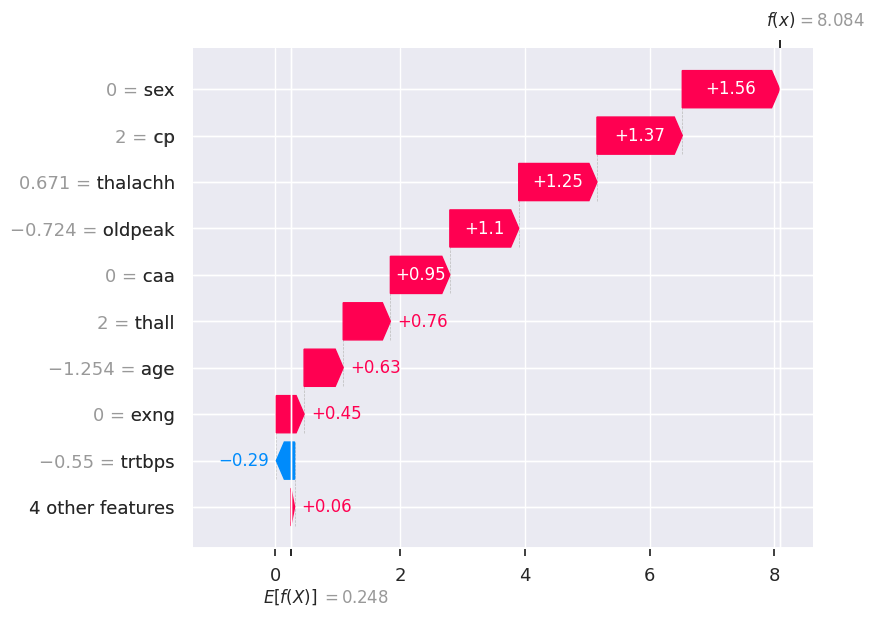

In [62]:
#gbtree non tuned

import shap

# SHAP explainer 생성
explainer = shap.Explainer(model_xgb)

# SHAP values 계산
shap_values = explainer(X_train)

# 모델 예측에 대한 SHAP 요약값 계산
shap.summary_plot(shap_values, X_train)

# 개별 샘플에 대한 SHAP 값 계산
shap_values_single = explainer(X_train.iloc[0:1])

# 개별 샘플에 대한 SHAP 값 시각화
shap.plots.waterfall(shap_values_single[0], max_display=10)

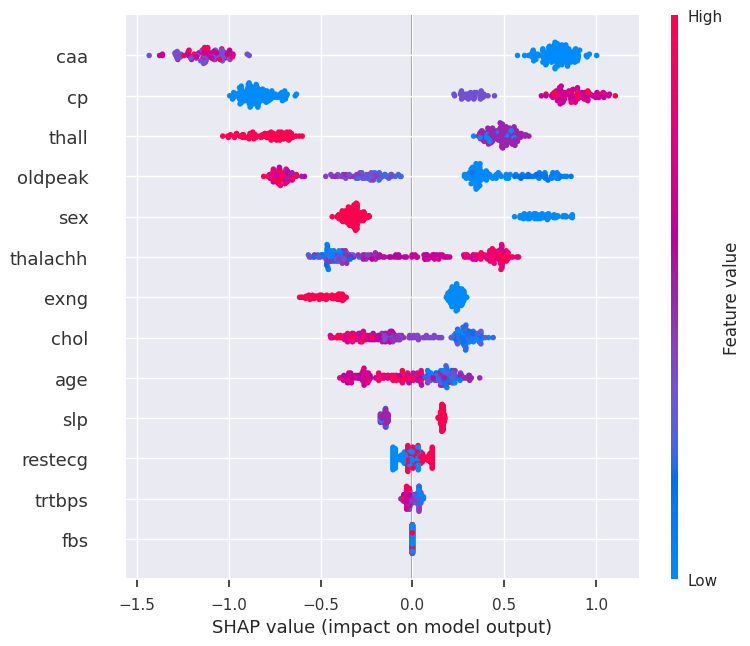

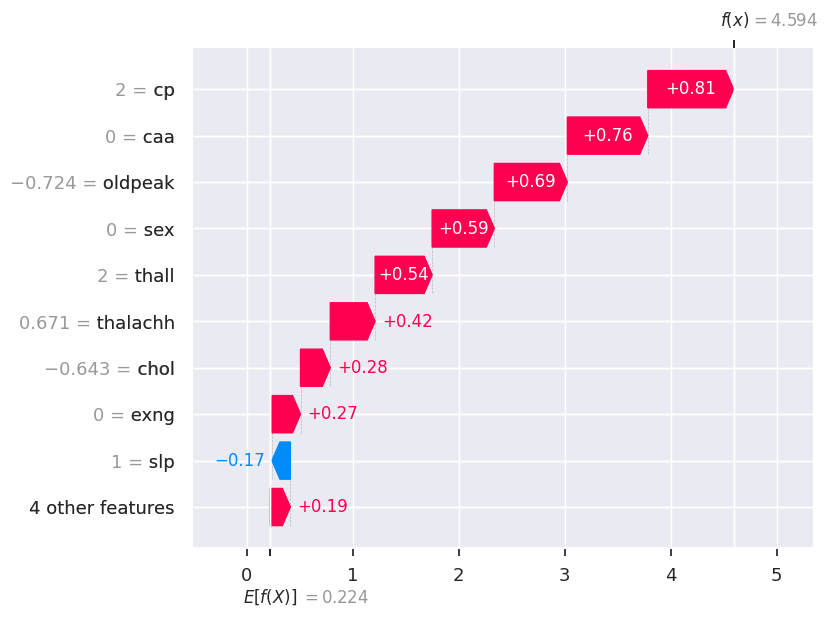

In [65]:
#gbtree tuned

import shap

# SHAP explainer 생성
explainer = shap.Explainer(model_xgb4)

# SHAP values 계산
shap_values = explainer(X_train)

# 모델 예측에 대한 SHAP 요약값 계산
shap.summary_plot(shap_values, X_train)

# 개별 샘플에 대한 SHAP 값 계산
shap_values_single = explainer(X_train.iloc[0:1])

# 개별 샘플에 대한 SHAP 값 시각화
shap.plots.waterfall(shap_values_single[0], max_display=10)



-정상범위에서 넘어가는 영역에 있는 데이터를 근접값으로 치환하여 데이터 처리

-데이터 처리후 Feature Importance, ShapValue 확인
